# Prognoza temperatury SARIMA

In [218]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler


plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df = pd.read_csv(DATA_DIR / 'combined.csv', parse_dates=['time'], index_col='time')

sarima
dla argegacji po 2h:
DAY   RMSE: 1.4898735991803695 MAE: 1.171840592240717
NIGHT RMSE: 0.7655131275872993 MAE: 0.6257273012242588

dla agregacji po 3h:
DAY   RMSE: 1.8727831610415733 MAE: 1.453969318717342
NIGHT RMSE: 1.2449239408223858 MAE: 1.0378308433462706



In [219]:
# RESAMPLE_I,RESAMPLE_S = 2,"2h"
RESAMPLE_I,RESAMPLE_S = 3,"3h"
# RESAMPLE_I,RESAMPLE_S = 4,"4h"
# RESAMPLE_I,RESAMPLE_S = 6,"6h"
# expanding mean from temt from the past for this day of year
df = df.sort_index()
df["doy"] = df.index.dayofyear
df["climatology"] = (
    df
    .groupby("doy")["temp"]
    .transform(lambda s: s.expanding().mean().shift(1))
)

df = df.dropna(subset=["climatology"])

df = df.loc["2023-01-01":]
df = df.resample(RESAMPLE_S).mean()


Lagi/snapshoty

- dane są co 3h (00, 03, 06, 09, 12, 15, 18, 21)
- dzień: 06:00–18:00 - snapshot informacyjny: 05:00 tego samego dnia
(w praktyce najbliższy wcześniejszy punkt to 03:00)
- noc: 18:00–06:00 - snapshot informacyjny: 17:00 przed nocą
(najbliższy wcześniejszy punkt to 15:00)

Czyli:

- dla godzin dziennych używamy danych z 03:00 tego samego dnia,
- dla godzin nocnych używamy danych z 15:00 dnia poprzedzającego noc.

In [220]:
df["hour"] = df.index.hour
df["date"] = df.index.date

def period_of_day(hour):
    if 6 <= hour < 18:
        return "day"
    else:
        return "night"

df["period"] = df["hour"].apply(period_of_day)

def snapshot_time(ts):
    date = ts.date()
    hour = ts.hour

    if 6 <= hour < 18:
        # dzień → 03:00 tego samego dnia
        return pd.Timestamp(date) + pd.Timedelta(hours=3)
    else:
        # noc
        if hour >= 18:
            # wieczór → 15:00 tego samego dnia
            return pd.Timestamp(date) + pd.Timedelta(hours=15)
        else:
            # po północy → 15:00 dnia poprzedniego
            return pd.Timestamp(date - pd.Timedelta(days=1)) + pd.Timedelta(hours=15)
df["snapshot_ts"] = df.index.map(snapshot_time)
snapshot_df = df.loc[df.index.isin(df["snapshot_ts"].unique())].copy()
snapshot_df = snapshot_df.add_suffix("_snap")
snapshot_df.index.name = "snapshot_ts"
df = df.merge(
    snapshot_df,
    left_on="snapshot_ts",
    right_index=True,
    how="left"
)
df["pres_trend"] = df["pres_snap"] - df["pres_snap"].shift(1)
df["temp_trend"] = df["temp_snap"] - df["temp_snap"].shift(1)
df["prcp_trend"] = df["prcp_snap"] - df["prcp_snap"].shift(1)
df["dew_point_approx"] = (
    df["temp_snap"] - ((100 - df["rhum_snap"]) / 5)
)

df['day_year_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
df['day_year_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

df = df.dropna()

test_hours = 24 // RESAMPLE_I * 365
train, test = df.iloc[:-test_hours], df.iloc[-test_hours:]

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")

Train set: 2023-01-01 to 2024-12-31
Test set: 2024-12-31 to 2025-12-31


In [221]:
exog_cols = [
    "day_year_sin",
    "day_year_cos",
    "climatology",
    # "pres_snap",
    # "rhum_snap",
    # "cldc_snap",
    # "wspd_snap",
    # "prcp_snap",
    "pres_trend",
    # "temp_trend",
    # "prcp_trend",
    "dew_point_approx",
]
target_col = "temp"

y_train = train[target_col]
y_test = test[target_col]

exog_train = train[exog_cols]
exog_test = test[exog_cols]

scaler = StandardScaler()
exog_train = scaler.fit_transform(exog_train)
exog_test = scaler.transform(exog_test)

In [222]:
s= 24 / RESAMPLE_I
model = SARIMAX(
    y_train,
    exog=exog_train,
    # v1
    # order=(2, 0, 1),
    # seasonal_order=(1, 0, 1, s),  # s=24/3=8
    # v2
    # order=(2, 0, 2),
    # seasonal_order=(1, 0, 1, s),
    # v3
    order=(3, 0, 2),
    seasonal_order=(2, 0, 1, s),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

result = model.fit(disp=False, maxiter=50)

forecast = result.get_forecast(steps=len(y_test), exog=exog_test)

y_pred = forecast.predicted_mean
y_pred.name = "temp_pred"

print(result.summary())

/home/werka/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                 5838
Model:             SARIMAX(3, 0, 2)x(2, 0, [1], 8)   Log Likelihood              -10327.449
Date:                             Sun, 08 Feb 2026   AIC                          20682.897
Time:                                     16:22:57   BIC                          20776.261
Sample:                                 01-01-2023   HQIC                         20715.370
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2047      0.769      0.266      0.790      -1.302       1.712
x2            -1.4783      

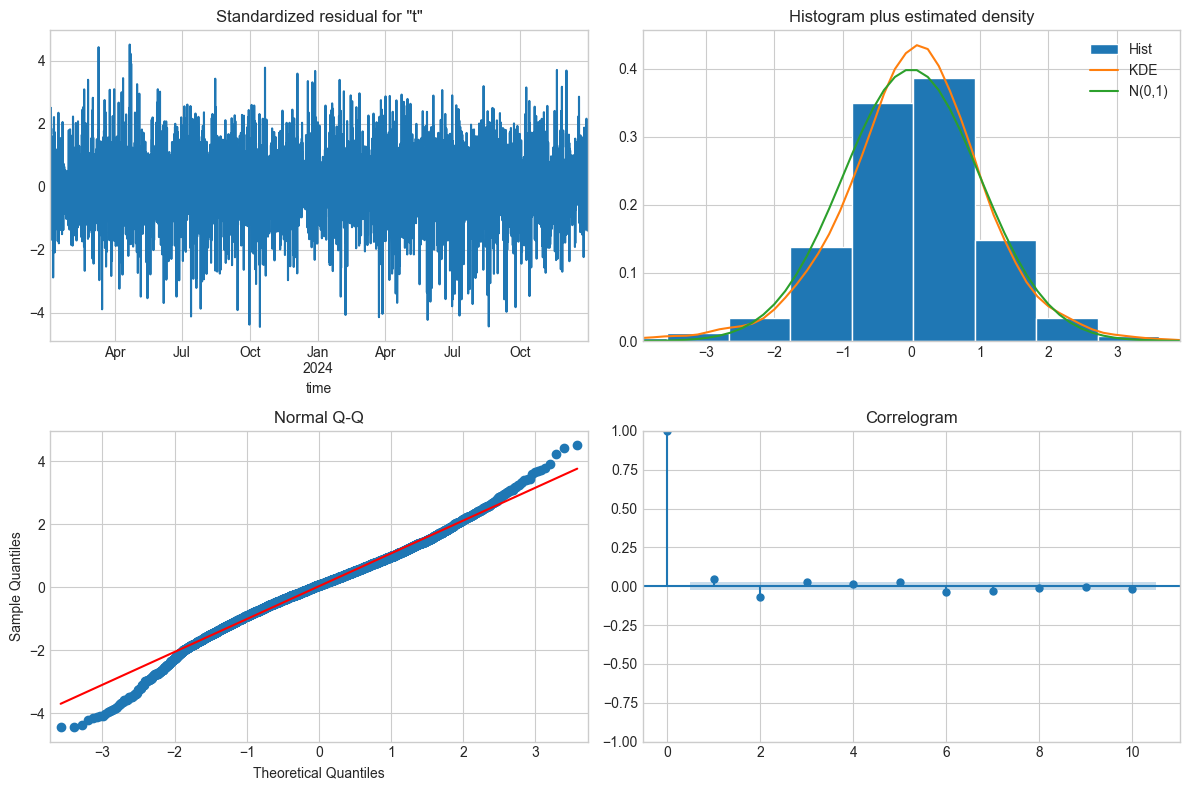

In [223]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()


In [224]:
df_eval = pd.concat([y_test, y_pred], axis=1).dropna()

df_eval["hour"] = df_eval.index.hour
df_eval["date"] = df_eval.index.date

def day_night_agg(df, col):
    day_mask = df.index.hour.isin(range(6,18))

    day = df.loc[day_mask, col].mean()
    night = df.loc[~day_mask, col].mean()

    return pd.Series({
        "day": day,
        "night": night
    })

true_agg = (
    df_eval.groupby(df_eval.index.date)
    .apply(day_night_agg, col="temp")
)
pred_agg = (
    df_eval.groupby(df_eval.index.date)
    .apply(day_night_agg, col="temp_pred")
)

# Żeby nie było NaN
day_df = pd.concat(
    [true_agg["day"], pred_agg["day"]],
    axis=1,
    keys=["true", "pred"]
).dropna()

night_df = pd.concat(
    [true_agg["night"], pred_agg["night"]],
    axis=1,
    keys=["true", "pred"]
).dropna()

In [225]:

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

day_rmse, day_mae = metrics(day_df["true"], day_df["pred"])
night_rmse, night_mae = metrics(night_df["true"], night_df["pred"])

print("DAY   RMSE:", day_rmse, "MAE:", day_mae)
print("NIGHT RMSE:", night_rmse, "MAE:", night_mae)


DAY   RMSE: 7.956286359619154 MAE: 7.010778697609255
NIGHT RMSE: 4.256466507266733 MAE: 3.6566368206656468


In [226]:
def show_results_sarima(true_agg, pred_agg, subset=60):
    """
    true_agg, pred_agg:
        DataFrame z kolumnami ['day', 'night']
        index = date
    """

    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # --- Dzień ---
    ax[0].plot(
        true_agg.index[-subset:],
        true_agg["day"].values[-subset:],
        "o-",
        color="orange",
        label="Rzeczywista (Dzień)",
        alpha=0.6,
    )
    ax[0].plot(
        pred_agg.index[-subset:],
        pred_agg["day"].values[-subset:],
        "x--",
        color="black",
        label="Prognoza SARIMAX",
    )
    ax[0].set_title("Prognoza Dnia - SARIMAX")
    ax[0].legend()

    # --- Noc ---
    ax[1].plot(
        true_agg.index[-subset:],
        true_agg["night"].values[-subset:],
        "o-",
        color="navy",
        label="Rzeczywista (Noc)",
        alpha=0.6,
    )
    ax[1].plot(
        pred_agg.index[-subset:],
        pred_agg["night"].values[-subset:],
        "x--",
        color="red",
        label="Prognoza SARIMAX",
    )
    ax[1].set_title("Prognoza Nocy - SARIMAX")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

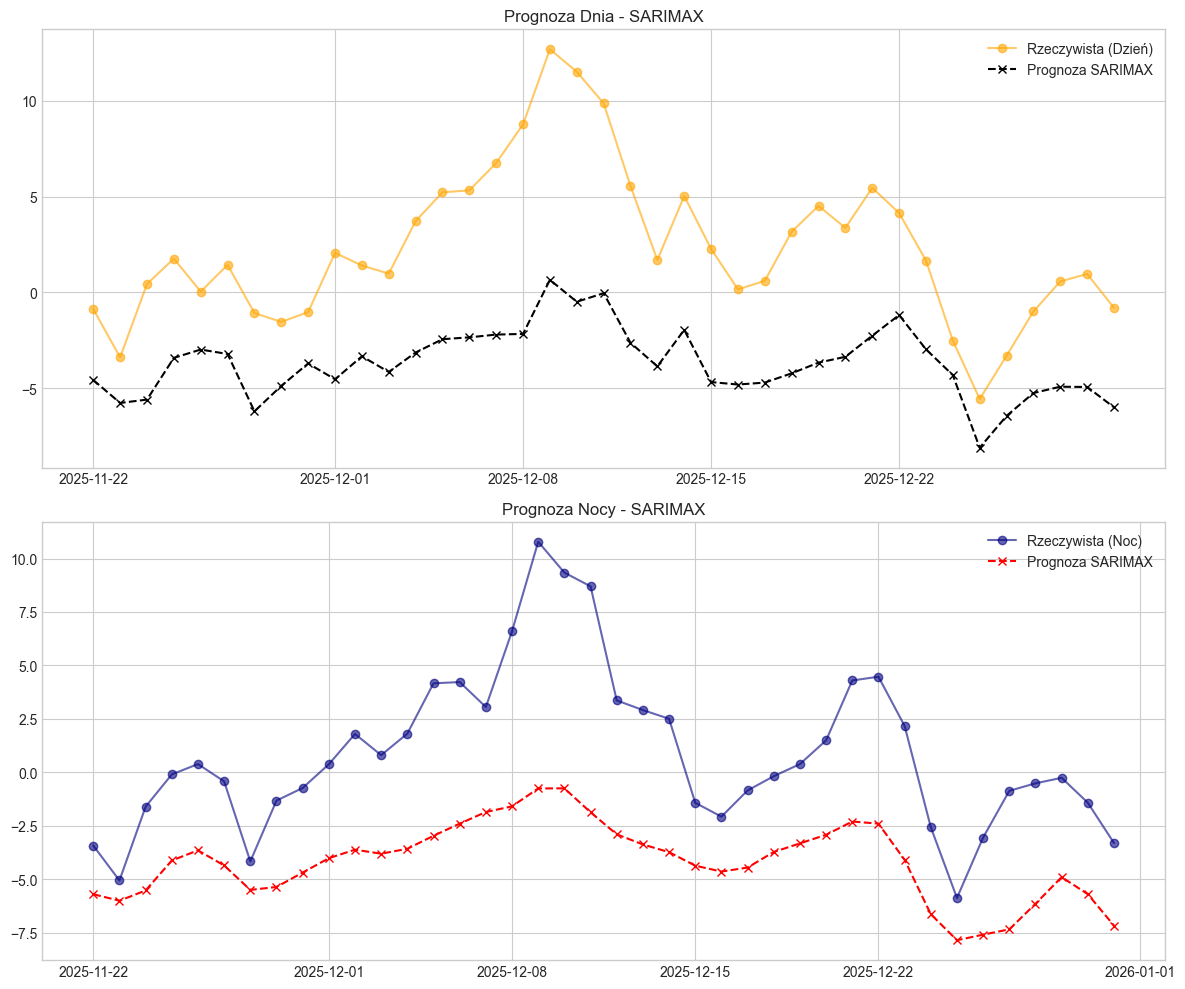

In [227]:
show_results_sarima(true_agg, pred_agg, subset=40)
